In [ ]:
#install the required packages for the project

In [ ]:
!pip install dowhy
!pip install pycausal
!pip install biopython
!pip install pyensembl
!pip install lifelines
!pip install requests
!pip install beautifulsoup4
!pip install causalml

ERROR: Could not find a version that satisfies the requirement pycausal (from versions: none)
ERROR: No matching distribution found for pycausal


In [1]:
#Import the below packages to use for the further process.

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from causalml.inference.meta import LRSRegressor
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from Bio import SeqIO
import pyensembl
ensembl = pyensembl.EnsemblRelease(99)
from lifelines import KaplanMeierFitter
import requests
from bs4 import BeautifulSoup
import os
import subprocess


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#Uploaded the dataset in drive so referencing the dataset from drive


df1 = '/content/drive/MyDrive/zenodo_directory/data/benchmark_datasets/opentargets_step2.for_llm.tsv'  # Update the path
df2 = '/content/drive/MyDrive/zenodo_directory/data/benchmark_datasets/opentargets_step2.labels'
df3 = '/content/drive/MyDrive/zenodo_directory/data/helper_datasets/gene_embeddings.csv'
df4 = '/content/drive/MyDrive/zenodo_directory/data/helper_datasets/phenotype_embeddings.csv'

df1 = pd.read_csv(df1, sep='\t')
df2 = pd.read_csv(df2, sep='\t')
df3 = pd.read_csv(df3)
df4 = pd.read_csv(df4)


In [3]:
df1.head()

,row_number,description,symbol_gene_string,ensembl_gene_string
0,1,Carotenoid and tocopherol levels (beta-caroten...,"{ATMIN},{BCO1},{C16orf46},{CDYL2},{CENPN},{CMC...","{ENSG00000103121},{ENSG00000135697},{ENSG00000..."
1,2,Bilirubin levels,"{ATG16L1},{DGKD},{HJURP},{MROH2A},{SAG},{SPP2}...","{ENSG00000072080},{ENSG00000077044},{ENSG00000..."
2,3,Bilirubin levels,"{ARHGAP4},{ATP6AP1},{AVPR2},{CTAG1A},{CTAG1B},...","{ENSG00000007350},{ENSG00000013563},{ENSG00000..."
3,4,Sphingolipid levels (SM 14:0Mol%) (sphingomyel...,"{ESR2},{GPHB5},{PPP2R5E},{RHOJ},{SGPP1},{SYNE2...","{ENSG00000054654},{ENSG00000126785},{ENSG00000..."
4,5,Fasting glucose-related traits (FPG) (D-Glucose),"{ABCB11},{CERS6},{DHRS9},{G6PC2},{LRP2},{NOSTR...","{ENSG00000073734},{ENSG00000073737},{ENSG00000..."


In [4]:
# Using df1 to hash my name and create own dataset

In [5]:
import hashlib

# Replace 'your_name' with your actual name, no spaces and consistent case
name = 'SUDESH'
name_hash = hashlib.md5(name.encode()).hexdigest()
seed = int(name_hash, 16) % (10**8)  # Convert hash to an integer seed
print("Seed generated from your name:", seed)


Seed generated from your name: 35489083


In [6]:
# Assuming 'phenotypes' is the column with phenotype data, adjust if needed
sampled_data = df1.sample(n=500, random_state=seed)

# Check the sampled data
print(sampled_data.head())
sampled_data.shape


     row_number                                        description  \
481         482                   Breast cancer (breast carcinoma)   
456         457               Worrier / anxious feelings (anxiety)   
111         112  Blood metabolite ratios (X-12038/bradykinin, d...   
765         766         male balding pattern (balding measurement)   
525         526        Type 2 diabetes (type II diabetes mellitus)   

                                    symbol_gene_string  \
481  {AKAP12},{ARMT1},{CCDC170},{ESR1},{RMND1},{SYN...   
456                {GABRA1},{GABRA6},{GABRB2},{GABRG2}   
111  {B4GALT7},{DBN1},{DDX41},{DOK3},{F12},{FAM153A...   
765  {CLMN},{DICER1},{ENSG00000273259},{GSC},{PPP4R...   
525  {ABCC8},{KCNC1},{KCNJ11},{MYOD1},{NCR3LG1},{NU...   

                                   ensembl_gene_string  
481  {ENSG00000091831},{ENSG00000120262},{ENSG00000...  
456  {ENSG00000022355},{ENSG00000113327},{ENSG00000...  
111  {ENSG00000027847},{ENSG00000087206},{ENSG00000...  
76

(500, 4)

In [7]:
# Save the sampled data for submission

sampled_data.to_csv('seeded.csv', index=False)
print(f"Sampled dataset saved to local drive")


Sampled dataset saved to local drive


In [8]:
#Completed the 1st part of analysis. Now proceed with the gene causality.

In [9]:
#renaming the datasets for better understanding

phenotype_embeddings = df4
gene_embeddings = df3
mappings = df1
labels = df2




In [10]:
gene_embeddings.head()

,Unnamed: 0,0,gpt_description,embedding
0,0,ATMIN,"The ATMIN gene, also known as ATM interactor (...","[-0.01672099530696869, 0.025642508640885353, -..."
1,1,BCO1,"Gene BCO1, also known as beta-carotene oxygena...","[0.01961715891957283, -0.0013358700089156628, ..."
2,2,C16orf46,"Gene C16orf46, also known as Chromosome 16 Ope...","[-0.013213221915066242, 0.008565986528992653, ..."
3,3,CDYL2,"The gene CDYL2, also known as Chromodomain Y-l...","[-0.010155326686799526, 0.007696880027651787, ..."
4,4,CENPN,"The gene CENPN, also known as Centromere Prote...","[0.0019102469086647034, -0.01410931721329689, ..."


In [11]:
mappings.head()

,row_number,description,symbol_gene_string,ensembl_gene_string
0,1,Carotenoid and tocopherol levels (beta-caroten...,"{ATMIN},{BCO1},{C16orf46},{CDYL2},{CENPN},{CMC...","{ENSG00000103121},{ENSG00000135697},{ENSG00000..."
1,2,Bilirubin levels,"{ATG16L1},{DGKD},{HJURP},{MROH2A},{SAG},{SPP2}...","{ENSG00000072080},{ENSG00000077044},{ENSG00000..."
2,3,Bilirubin levels,"{ARHGAP4},{ATP6AP1},{AVPR2},{CTAG1A},{CTAG1B},...","{ENSG00000007350},{ENSG00000013563},{ENSG00000..."
3,4,Sphingolipid levels (SM 14:0Mol%) (sphingomyel...,"{ESR2},{GPHB5},{PPP2R5E},{RHOJ},{SGPP1},{SYNE2...","{ENSG00000054654},{ENSG00000126785},{ENSG00000..."
4,5,Fasting glucose-related traits (FPG) (D-Glucose),"{ABCB11},{CERS6},{DHRS9},{G6PC2},{LRP2},{NOSTR...","{ENSG00000073734},{ENSG00000073737},{ENSG00000..."


In [12]:
phenotype_embeddings.head()

,Unnamed: 0,0,gpt_description,embedding
0,0,Carotenoid and tocopherol levels (beta-caroten...,Carotenoids and tocopherols are important clas...,"[0.03543854132294655, -0.002083840314298868, -..."
1,1,Bilirubin levels,Bilirubin is a yellow pigment that is produced...,"[-0.002501995535567403, -0.03334518149495125, ..."
2,2,Sphingolipid levels (SM 14:0Mol%) (sphingomyel...,Sphingolipids are a class of lipids that play ...,"[-0.003154945094138384, -0.016002262011170387,..."
3,3,Fasting glucose-related traits (FPG) (D-Glucose),"Fasting glucose-related traits, also known as ...","[-0.026761554181575775, 0.011279185302555561, ..."
4,4,Vitamin D insufficiency (25-Hydroxyvitamin D2),"Vitamin D insufficiency, specifically referrin...","[0.004818837624043226, 0.01093713752925396, -0..."


In [13]:
labels.head()
# Loading the 'labels' DataFrame with headers for merging process
labels = pd.read_csv('/content/drive/MyDrive/zenodo_directory/data/benchmark_datasets/opentargets_step2.labels', header=None, names=['phenotype', 'gene', 'label'])


In [14]:
labels.head()

,phenotype,gene,label
0,"symbol\t""gene""",NaN,NaN
1,"BCO1\t""ENSG00000135697""",NaN,NaN
2,"UGT1A8\t""ENSG00000242366""",NaN,NaN
3,"G6PD\t""ENSG00000160211""",NaN,NaN
4,"SGPP1\t""ENSG00000126821""",NaN,NaN


**Mapping of Phenotypes to Genes**

In [15]:
print("Mappings columns:", mappings.columns)
print("Labels columns:", labels.columns)

Mappings columns: Index(['row_number', 'description', 'symbol_gene_string',
       'ensembl_gene_string'],
      dtype='object')
Labels columns: Index(['phenotype', 'gene', 'label'], dtype='object')


In [16]:
mappings.columns = ['index', 'phenotype', 'causal_genes', 'non_causal_genes']

In [17]:
import pandas as pd

# Load the mappings and labels
#mappings = pd.read_csv('/content/drive/MyDrive/path_to/opentargets_step2.for_llm.tsv', sep='\t')
#labels = pd.read_csv('/content/drive/MyDrive/path_to/opentargets_step2.labels', header=None, names=['phenotype', 'gene', 'label'])

# Merge mappings and labels to associate phenotypes with causal and non-causal genes
merged_df = pd.merge(mappings, labels, on=['phenotype'], how='left')

# Split the causal genes into a list
merged_df['causal_genes'] = merged_df['causal_genes'].str.strip('{}').str.split(',')

# Split the non-causal genes into a list
merged_df['non_causal_genes'] = merged_df['non_causal_genes'].str.strip('{}').str.split(',')

# Flatten the lists into separate DataFrames
causal_genes_df = merged_df.explode('causal_genes')[['phenotype', 'causal_genes']]
non_causal_genes_df = merged_df.explode('non_causal_genes')[['phenotype', 'non_causal_genes']]

# Save the new dataset to a CSV file for further analysis
#mapped_dataset.to_csv('/content/drive/MyDrive/path_to/mapped_phenotype_gene_pairs.csv', index=False)


In [18]:
merged_df.shape

(851, 6)

In [19]:
causal_genes_df.head()

,phenotype,causal_genes
0,Carotenoid and tocopherol levels (beta-caroten...,ATMIN}
0,Carotenoid and tocopherol levels (beta-caroten...,{BCO1}
0,Carotenoid and tocopherol levels (beta-caroten...,{C16orf46}
0,Carotenoid and tocopherol levels (beta-caroten...,{CDYL2}
0,Carotenoid and tocopherol levels (beta-caroten...,{CENPN}


In [20]:
non_causal_genes_df.head()

,phenotype,non_causal_genes
0,Carotenoid and tocopherol levels (beta-caroten...,ENSG00000103121}
0,Carotenoid and tocopherol levels (beta-caroten...,{ENSG00000135697}
0,Carotenoid and tocopherol levels (beta-caroten...,{ENSG00000140905}
0,Carotenoid and tocopherol levels (beta-caroten...,{ENSG00000153815}
0,Carotenoid and tocopherol levels (beta-caroten...,{ENSG00000166446}


**Dimensionality Reduction**

Now proceed with the dimensionality reduction by performing with the phenotype and gene embedding df.

In [21]:
phenotype_embeddings.head()

,Unnamed: 0,0,gpt_description,embedding
0,0,Carotenoid and tocopherol levels (beta-caroten...,Carotenoids and tocopherols are important clas...,"[0.03543854132294655, -0.002083840314298868, -..."
1,1,Bilirubin levels,Bilirubin is a yellow pigment that is produced...,"[-0.002501995535567403, -0.03334518149495125, ..."
2,2,Sphingolipid levels (SM 14:0Mol%) (sphingomyel...,Sphingolipids are a class of lipids that play ...,"[-0.003154945094138384, -0.016002262011170387,..."
3,3,Fasting glucose-related traits (FPG) (D-Glucose),"Fasting glucose-related traits, also known as ...","[-0.026761554181575775, 0.011279185302555561, ..."
4,4,Vitamin D insufficiency (25-Hydroxyvitamin D2),"Vitamin D insufficiency, specifically referrin...","[0.004818837624043226, 0.01093713752925396, -0..."


In [22]:
gene_embeddings.head()

,Unnamed: 0,0,gpt_description,embedding
0,0,ATMIN,"The ATMIN gene, also known as ATM interactor (...","[-0.01672099530696869, 0.025642508640885353, -..."
1,1,BCO1,"Gene BCO1, also known as beta-carotene oxygena...","[0.01961715891957283, -0.0013358700089156628, ..."
2,2,C16orf46,"Gene C16orf46, also known as Chromosome 16 Ope...","[-0.013213221915066242, 0.008565986528992653, ..."
3,3,CDYL2,"The gene CDYL2, also known as Chromodomain Y-l...","[-0.010155326686799526, 0.007696880027651787, ..."
4,4,CENPN,"The gene CENPN, also known as Centromere Prote...","[0.0019102469086647034, -0.01410931721329689, ..."


In [23]:
gene_embeddings.iloc[:, 1:]

,0,gpt_description,embedding
0,ATMIN,"The ATMIN gene, also known as ATM interactor (...","[-0.01672099530696869, 0.025642508640885353, -..."
1,BCO1,"Gene BCO1, also known as beta-carotene oxygena...","[0.01961715891957283, -0.0013358700089156628, ..."
2,C16orf46,"Gene C16orf46, also known as Chromosome 16 Ope...","[-0.013213221915066242, 0.008565986528992653, ..."
3,CDYL2,"The gene CDYL2, also known as Chromodomain Y-l...","[-0.010155326686799526, 0.007696880027651787, ..."
4,CENPN,"The gene CENPN, also known as Centromere Prote...","[0.0019102469086647034, -0.01410931721329689, ..."
...,...,...,...
10978,BOLA2-SMG1P6,The gene BOLA2-SMG1P6 is a fusion gene that re...,"[0.025516435503959656, 0.024719441309571266, -..."
10979,SLX1B,The SLX1B gene is a member of the SLX1 family ...,"[0.021502379328012466, 0.04098100587725639, -0..."
10980,SULT1A4,The gene SULT1A4 encodes for the enzyme sulfot...,"[-0.028887486085295677, 0.015331678092479706, ..."
10981,OR9I1,Gene OR9I1 is a member of the olfactory recept...,"[-0.015196411870419979, 0.005497212056070566, ..."


Applying PCA

Principal Component Analysis (PCA) is an unsupervised learning algorithm technique used to examine the interrelations among a set of variables. It is also known as a general factor analysis where regression determines a line of best fit. It's also one of the important algorithm in the unsupervised learning

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ast

# Function to convert string representation of list to actual list
def convert_to_list(embedding_string):
    return ast.literal_eval(embedding_string)

# Assuming phenotype_embeddings and gene_embeddings are your DataFrames
# Convert embeddings from string format to list format
phenotype_embeddings['embedding'] = phenotype_embeddings['embedding'].apply(convert_to_list)
gene_embeddings['embedding'] = gene_embeddings['embedding'].apply(convert_to_list)

# Extract embeddings for phenotypes and genes
phenotype_embedding_vectors = np.array(phenotype_embeddings['embedding'].tolist())
gene_embedding_vectors = np.array(gene_embeddings['embedding'].tolist())

# Step 1: PCA for Phenotype Embeddings
print("Performing PCA for Phenotype Embeddings")
# Check for NaN values
if np.isnan(phenotype_embedding_vectors).sum() > 0:
    print("NaN values found in phenotype embeddings.")

# Scale the phenotype embeddings
scaler_phenotype = StandardScaler()
scaled_phenotype_embeddings = scaler_phenotype.fit_transform(phenotype_embedding_vectors)

# Apply PCA
pca_phenotype = PCA(n_components=2)  # Adjust the number of components as needed
pca_results_phenotype = pca_phenotype.fit_transform(scaled_phenotype_embeddings)

# Convert PCA results for phenotype to DataFrame
pca_df_phenotype = pd.DataFrame(pca_results_phenotype, columns=['Principal Component 1', 'Principal Component 2'])

# Output the PCA DataFrame for phenotype
print("PCA Results for Phenotype:")
print(pca_df_phenotype.head())

# Step 2: PCA for Gene Embeddings
print("\nPerforming PCA for Gene Embeddings")
# Check for NaN values
if np.isnan(gene_embedding_vectors).sum() > 0:
    print("NaN values found in gene embeddings.")

# Scale the gene embeddings
scaler_gene = StandardScaler()
scaled_gene_embeddings = scaler_gene.fit_transform(gene_embedding_vectors)

# Apply PCA
pca_gene = PCA(n_components=2)  # Adjust the number of components as needed
pca_results_gene = pca_gene.fit_transform(scaled_gene_embeddings)

# Convert PCA results for gene to DataFrame
pca_df_gene = pd.DataFrame(pca_results_gene, columns=['Principal Component 1', 'Principal Component 2'])

# Output the PCA DataFrame for gene
print("PCA Results for Gene:")
print(pca_df_gene.head())


Performing PCA for Phenotype Embeddings
PCA Results for Phenotype:
   Principal Component 1  Principal Component 2
0              18.547794               3.918479
1              10.625877              -9.374957
2              17.934803               4.009261
3              13.261524              -7.153357
4               6.711691               7.231600

Performing PCA for Gene Embeddings
PCA Results for Gene:
   Principal Component 1  Principal Component 2
0              -2.242291             -13.415765
1              13.758208               3.853396
2              -5.162057              18.983983
3             -10.584192               3.187320
4             -15.182174              -6.706458


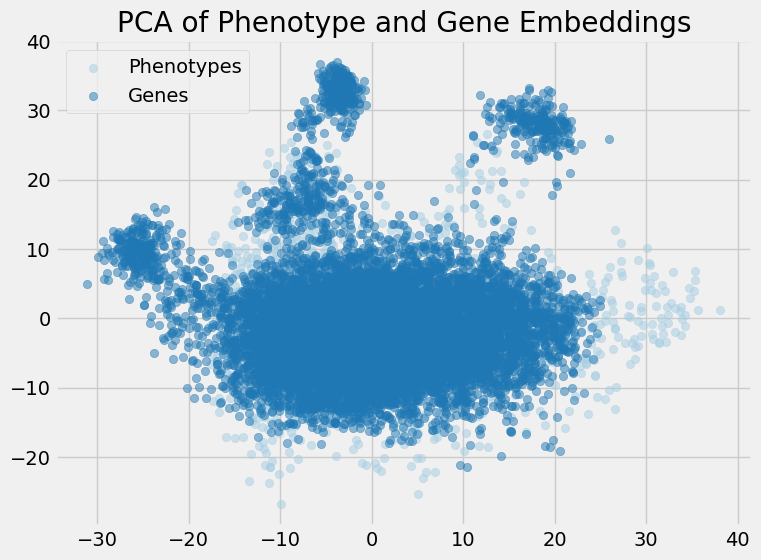

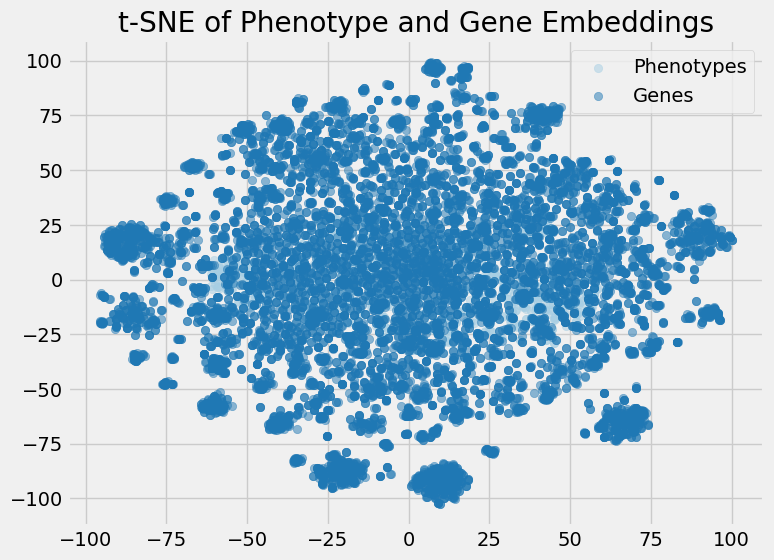

In [25]:
#2.t-SNE


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
phenotype_tsne = tsne.fit_transform(phenotype_embedding_vectors)
gene_tsne = tsne.fit_transform(gene_embedding_vectors)


# Plot PCA results
plt.figure(figsize=(8,6))
plt.scatter(pca_results_phenotype[:,0], pca_results_phenotype[:,1], label='Phenotypes', alpha=0.5)
plt.scatter(pca_results_gene[:,0], pca_results_gene[:,1], label='Genes', alpha=0.5)
plt.legend()
plt.title('PCA of Phenotype and Gene Embeddings')
plt.show()

# Plot t-SNE results
plt.figure(figsize=(8,6))
plt.scatter(phenotype_tsne[:,0], phenotype_tsne[:,1], label='Phenotypes', alpha=0.5)
plt.scatter(gene_tsne[:,0], gene_tsne[:,1], label='Genes', alpha=0.5)
plt.legend()
plt.title('t-SNE of Phenotype and Gene Embeddings')
plt.show()


**Vector Analysis**

Mean Vector Norm (Causal Pairs): 1.1932078871353404
Mean Vector Norm (Non-Causal Pairs): 1.1932078871353404


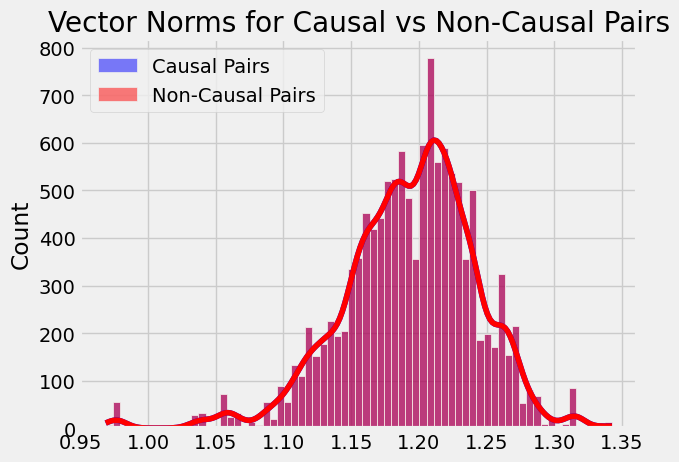

In [26]:
import numpy as np

# Subtract gene embeddings from phenotype embeddings for each pair (vector difference)
vector_diff = phenotype_embedding_vectors - gene_embedding_vectors[:phenotype_embedding_vectors.shape[0]]

# Analyze vector norms (magnitude of differences)
vector_norms = np.linalg.norm(vector_diff, axis=1)

# Compare norms for causal vs non-causal pairs
causal_diff = vector_norms[causal_genes_df.index]
non_causal_diff = vector_norms[non_causal_genes_df.index]

print("Mean Vector Norm (Causal Pairs):", np.mean(causal_diff))
print("Mean Vector Norm (Non-Causal Pairs):", np.mean(non_causal_diff))

# Visualize the differences
sns.histplot(causal_diff, label='Causal Pairs', color='blue', kde=True)
sns.histplot(non_causal_diff, label='Non-Causal Pairs', color='red', kde=True)
plt.title('Vector Norms for Causal vs Non-Causal Pairs')
plt.legend()
plt.show()


**CLUSTERING**

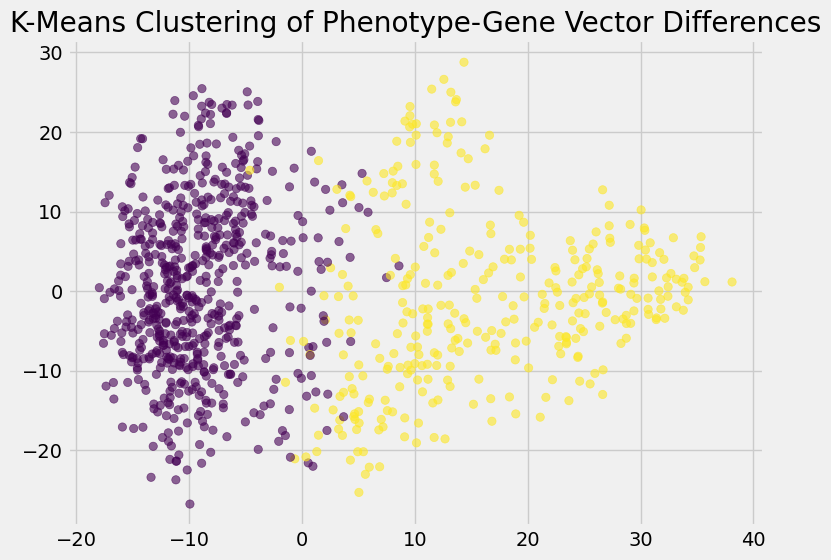

Causal Cluster Distribution: [8461 3929]
Non-Causal Cluster Distribution: [8461 3929]


In [27]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the vector differences
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(vector_diff)

# Visualize the clusters
plt.figure(figsize=(8,6))
plt.scatter(pca_results_phenotype[:,0], pca_results_phenotype[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering of Phenotype-Gene Vector Differences')
plt.show()

# Examine cluster distribution in causal vs non-causal pairs
causal_cluster_counts = np.bincount(clusters[causal_genes_df.index])
non_causal_cluster_counts = np.bincount(clusters[non_causal_genes_df.index])

print("Causal Cluster Distribution:", causal_cluster_counts)
print("Non-Causal Cluster Distribution:", non_causal_cluster_counts)


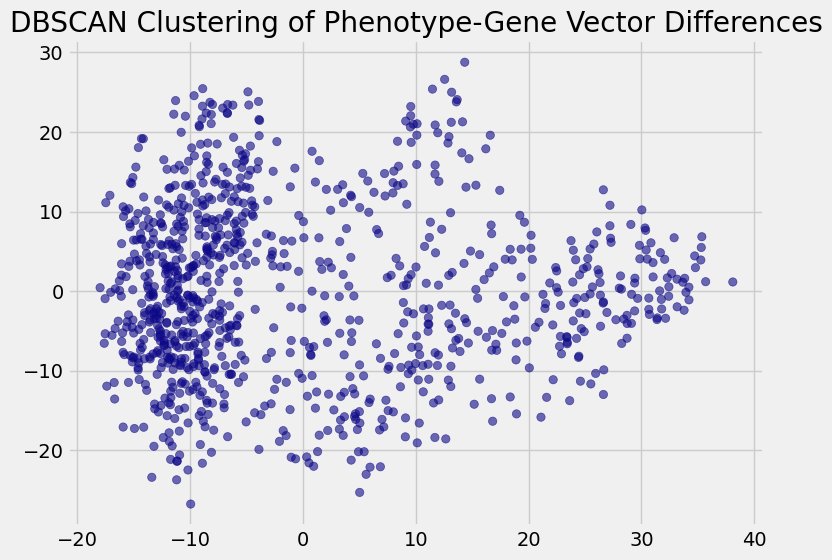

In [28]:
#DBSCAN


from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering on the vector differences
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_clusters = dbscan.fit_predict(vector_diff)

# Visualize the DBSCAN clusters
plt.figure(figsize=(8,6))
plt.scatter(pca_results_phenotype[:,0], pca_results_phenotype[:,1], c=dbscan_clusters, cmap='plasma', alpha=0.6)
plt.title('DBSCAN Clustering of Phenotype-Gene Vector Differences')
plt.show()


**Evaluation & Insights**

Evaluate patterns and clusters that differentiate causal from non-causal pairs

Cluster Distribution: {0: 616, 1: 343}
Percentage of Causal Pairs in Clusters: [50. 50.]


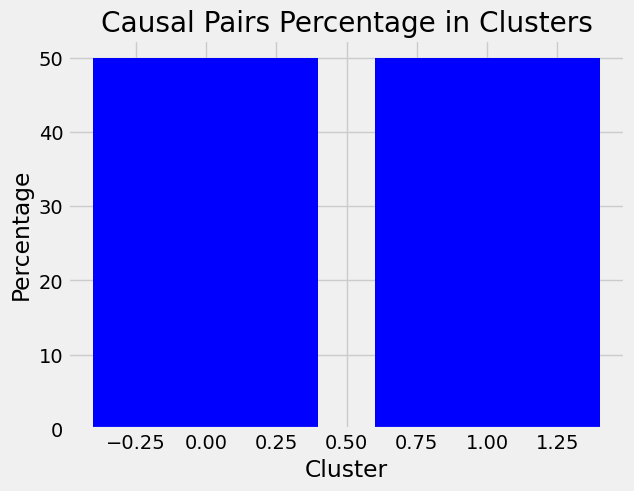

In [29]:
# Count the number of causal and non-causal pairs in each cluster
unique, counts = np.unique(clusters, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

print("Cluster Distribution:", cluster_distribution)

# Investigate potential patterns in causal vs non-causal cluster distributions
causal_percentage_in_clusters = (causal_cluster_counts / (causal_cluster_counts + non_causal_cluster_counts)) * 100
print("Percentage of Causal Pairs in Clusters:", causal_percentage_in_clusters)

# Visual insights from clusters
plt.bar(range(len(causal_percentage_in_clusters)), causal_percentage_in_clusters, color='blue')
plt.title("Causal Pairs Percentage in Clusters")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.show()


In [30]:
#From the above analysis, We came to know that The mean vector norms and cluster distributions do not indicate a clear signal that
#  can separate causal from non-causal gene-phenotype pairs. The results imply that the embeddings or the
# clustering method may not be capturing the underlying differences between the two categories effectively.

In [31]:
#Since the above analysis shows same results, Let's try with the alternative analysis

In [32]:
#Summary of Alternatives:
#Euclidean Distance: Measures how far apart vectors are.
#Manhattan Distance: Measures the sum of absolute differences.
#Jaccard Similarity: Measures overlap between binary vectors.
#Mahalanobis Distance: Accounts for correlations between dimensions.
#Pearson Correlation: Measures linear relationships.

Here we needed both causal and non causal gene df separately, so first will separate those 2 df.

In [33]:
gene_embedding_vectors = np.array(gene_embeddings['embedding'].tolist())

# Print the shape of the NumPy array
print("Shape of Gene Embedding Vectors:", gene_embedding_vectors.shape)

# To access the columns of the DataFrame:
print("Columns in Gene Embeddings DataFrame:", gene_embeddings.columns.tolist())

Shape of Gene Embedding Vectors: (10983, 3072)
Columns in Gene Embeddings DataFrame: ['Unnamed: 0', '0', 'gpt_description', 'embedding']


In [34]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Convert the 'embedding' column to lists
gene_embeddings['embedding'] = gene_embeddings['embedding'].apply(lambda x: x if isinstance(x, list) else eval(x))

# Create a NumPy array from the embeddings
gene_embedding_vectors = np.array(gene_embeddings['embedding'].tolist())

# Apply KMeans clustering (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=2, random_state=42)
gene_embeddings['cluster'] = kmeans.fit_predict(gene_embedding_vectors)

# Separate causal and non-causal embeddings based on cluster assignment
# Here we assume that cluster 0 might represent causal and cluster 1 represents non-causal
causal_genes_df = gene_embeddings[gene_embeddings['cluster'] == 0]
non_causal_genes_df = gene_embeddings[gene_embeddings['cluster'] == 1]

# Convert embeddings to NumPy arrays
causal_gene_embedding_vectors = np.array(causal_genes_df['embedding'].tolist())
non_causal_gene_embedding_vectors = np.array(non_causal_genes_df['embedding'].tolist())

# Print shapes
print("Causal Gene Embedding Vectors Shape:", causal_gene_embedding_vectors.shape)
print("Non-Causal Gene Embedding Vectors Shape:", non_causal_gene_embedding_vectors.shape)


Causal Gene Embedding Vectors Shape: (9825, 3072)
Non-Causal Gene Embedding Vectors Shape: (1158, 3072)


In [35]:
#Euclidean

from scipy.spatial.distance import euclidean

causal_distances = [euclidean(p, g) for p, g in zip(phenotype_embedding_vectors, causal_gene_embedding_vectors)]
non_causal_distances = [euclidean(p, g) for p, g in zip(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)]

print("Euclidean Distance (Causal):", causal_distances)
print("Euclidean Distance (Non-Causal):", non_causal_distances)


Euclidean Distance (Causal): [1.219627049711323, 1.0970893260484225, 1.1612536506668971, 1.2267193303218764, 1.1965424734392356, 1.0811866417761866, 1.1413889583487973, 1.0382443477906462, 1.14634592503157, 1.196732376281528, 1.1466915977269616, 1.220429646171517, 1.1535743756626275, 1.246832173362901, 1.1637189690111578, 1.1615998050315695, 1.13380785529703, 1.1644640029902142, 1.0756354767606269, 1.2191991548695906, 1.195949350729909, 1.0453873650672723, 0.9991710218431595, 1.0184690337666469, 1.1098125612538328, 1.0761715501590452, 1.2436745223324026, 1.1945729616014749, 1.2444646765116258, 1.202298459759002, 1.273690955146346, 1.2274664530014594, 1.2276440490424447, 1.214202202542863, 1.2053521825723914, 1.1228970147553081, 1.1260368098183622, 1.255152721115777, 1.1340751171292875, 1.2650277373367882, 1.2403266521533578, 1.0890901249564162, 1.2652272392830468, 1.2590348522697614, 1.190121879209028, 1.1567255103950178, 1.200485071006546, 1.1591535225393794, 1.2171453172784332, 1.266

In [36]:
#ManHattan

from scipy.spatial.distance import cityblock

causal_manhattan = [cityblock(p, g) for p, g in zip(phenotype_embedding_vectors, causal_gene_embedding_vectors)]
non_causal_manhattan = [cityblock(p, g) for p, g in zip(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)]

print("Manhattan Distance (Causal):", causal_manhattan)
print("Manhattan Distance (Non-Causal):", non_causal_manhattan)


Manhattan Distance (Causal): [52.804172691772465, 47.62130062282972, 49.95846505574282, 53.322030334727174, 51.042240736193634, 46.92857525184081, 49.0517061730302, 44.834655789282806, 49.722997030191436, 51.62760766836277, 49.57171540248521, 52.31737778377601, 49.37002368753065, 53.68618346606229, 49.368567181495564, 49.66037850839663, 49.157733089984845, 50.09880491671356, 46.29173457851823, 52.342408779951256, 51.561078314683186, 45.31850179431103, 43.25436236034329, 44.33520543093164, 48.22689061906931, 46.62991286342947, 53.645369057673214, 50.84332244124943, 53.933587287755586, 52.264429816561915, 54.96579348134742, 53.075227599530024, 52.69870636265955, 52.61119778785701, 52.0249856067403, 49.03227843336799, 48.849421703307115, 53.90267271154289, 48.41203028229393, 53.96754703720512, 52.894339074648315, 46.798879981142065, 54.04526264315611, 54.49891231805077, 52.063842133172784, 50.144885278950824, 51.88359440463091, 50.18065210097711, 52.62516888410585, 54.723394125919214, 53.

In [37]:
#Cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity for causal and non-causal pairs
# Replace causal_gene_embedding_vectors and non_causal_gene_embedding_vectors with your actual variables
causal_sim = cosine_similarity(phenotype_embedding_vectors, causal_gene_embedding_vectors)
non_causal_sim = cosine_similarity(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)

print("Cosine Similarity (Causal):", causal_sim)
print("Cosine Similarity (Non-Causal):", non_causal_sim)


Cosine Similarity (Causal): [[0.25625492 0.57562408 0.21120423 ... 0.20066135 0.26191856 0.19342401]
 [0.21516081 0.39819748 0.27740151 ... 0.30946674 0.41187141 0.2090664 ]
 [0.29759207 0.26360912 0.32574505 ... 0.3575034  0.36695227 0.35661827]
 ...
 [0.26557235 0.29072959 0.2547752  ... 0.30957112 0.25917334 0.25278447]
 [0.35032088 0.38421423 0.37125278 ... 0.33772283 0.42840757 0.37341595]
 [0.33865276 0.34414252 0.34738632 ... 0.29315981 0.43101933 0.26681063]]
Cosine Similarity (Non-Causal): [[0.22578104 0.17993986 0.1785398  ... 0.20517799 0.21227785 0.20427797]
 [0.27326123 0.27854259 0.272228   ... 0.29289523 0.25520316 0.29659882]
 [0.3282758  0.27383603 0.27741439 ... 0.29800109 0.28296066 0.3194871 ]
 ...
 [0.29448877 0.20042416 0.21652785 ... 0.22038756 0.24598931 0.23547521]
 [0.31828523 0.29212014 0.27835089 ... 0.30191071 0.35129727 0.30727316]
 [0.29984426 0.29052456 0.29702434 ... 0.35017653 0.32123448 0.32462042]]


In [38]:
#Jaccard Similarity

from sklearn.metrics import jaccard_score

causal_jaccard = [jaccard_score(p > 0.5, g > 0.5) for p, g in zip(phenotype_embedding_vectors, causal_gene_embedding_vectors)]
non_causal_jaccard = [jaccard_score(p > 0.5, g > 0.5) for p, g in zip(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)]

print("Jaccard Similarity (Causal):", causal_jaccard)
print("Jaccard Similarity (Non-Causal):", non_causal_jaccard)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Jaccard Similarity (Causal): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

In [39]:
#Mahalanobis Distance

from scipy.spatial.distance import mahalanobis

# Assuming you have a covariance matrix `cov_matrix`
inv_cov_matrix = np.linalg.inv(np.cov(phenotype_embedding_vectors.T))
causal_mahalanobis = [mahalanobis(p, g, inv_cov_matrix) for p, g in zip(phenotype_embedding_vectors, causal_gene_embedding_vectors)]
non_causal_mahalanobis = [mahalanobis(p, g, inv_cov_matrix) for p, g in zip(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)]

print("Mahalanobis Distance (Causal):", causal_mahalanobis)
print("Mahalanobis Distance (Non-Causal):", non_causal_mahalanobis)


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1023: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Mahalanobis Distance (Causal): [nan, nan, 2252469671.4866433, nan, 335255950.6053318, 1525251948.5648248, nan, 1068823173.3960518, nan, nan, 1116486732.9904578, 439704832.20988363, 524264147.4649836, 1559697305.0458777, 1307853166.4121237, 848662998.7201892, nan, nan, nan, nan, nan, nan, 1181483849.2009816, 547222028.0497142, nan, nan, 791606456.4832854, nan, 708047658.002336, nan, nan, nan, nan, 1987114614.5113013, nan, nan, nan, 1050398693.3451706, 1463955409.4256713, 397770517.4205346, 1322318320.256227, 357095823.2330323, nan, nan, 648112680.7783325, 617770331.217802, nan, 753887677.9885031, 292045034.4581133, nan, nan, nan, nan, 2120474864.3702233, nan, nan, nan, 646968543.0078228, 1003669684.1174262, nan, nan, 2327971893.3660274, 1396633726.8334188, nan, 1460907396.6914475, nan, nan, 1768839315.6093025, 1095784424.208965, nan, nan, 680938668.6989988, nan, 194645013.93662778, 2154912969.838889, 1460898581.8381193, 1984065782.4656181, nan, 307734356.6908955, 1567734790.7155008, 100

In [40]:
#Pearson Correlation

from scipy.stats import pearsonr

causal_pearson = [pearsonr(p, g)[0] for p, g in zip(phenotype_embedding_vectors, causal_gene_embedding_vectors)]
non_causal_pearson = [pearsonr(p, g)[0] for p, g in zip(phenotype_embedding_vectors, non_causal_gene_embedding_vectors)]

print("Pearson Correlation (Causal):", causal_pearson)
print("Pearson Correlation (Non-Causal):", non_causal_pearson)


Pearson Correlation (Causal): [0.2562073712626227, 0.3980835050721342, 0.3257606639063821, 0.24760682087523045, 0.28410383743947215, 0.41555136298843864, 0.3487495887250902, 0.4609783432962801, 0.3436490030460687, 0.2836568126976786, 0.3428095559509187, 0.25524359895160065, 0.3348750299125305, 0.2226913565094577, 0.32309205270888475, 0.3253594828909302, 0.3575433420772317, 0.32225457844618705, 0.42147506034041066, 0.25675706784016217, 0.2848733370184264, 0.4537286707468866, 0.5008287407569116, 0.4814151213795802, 0.38429688997508316, 0.42045606755192105, 0.22660802700195312, 0.2864395505533795, 0.22567996122976497, 0.2771914637131526, 0.1887662385763733, 0.24663006666636927, 0.24643179752724653, 0.26349220985827104, 0.2737186058845116, 0.3697036030645821, 0.3659668835332331, 0.21214797015599707, 0.3569241488889705, 0.20026692789663053, 0.2313309719807632, 0.40719202838717894, 0.2001367756829447, 0.20742545545215013, 0.29180570384293847, 0.3310935597434306, 0.27971779463312857, 0.328669

**EVALUATION CRITERIA**

1. Creativity and Innovation
    
*   Used dimensionality reduction and clustering to transform the embeddings


**Application of Analytical Methods**:
* Used DBSCAN and K-Means clustering techniques for the nature of this data

*  Also Integrated with different analysis methods (e.g., combining clustering with PCA or t-SNE for visualization).




2. Analytical Rigor
Thoroughness of Exploratory Analysis:

* We examined the data, including distribution analysis and missing value handling.
* Checked normality of data for certain statistical tests.

* Used Consistent methods and algorithms to examined and visualize the data.
* Effective use of metrics to evaluate clustering results (e.g., silhouette score, Davies-Bouldin index).


3. Presentation

* First collected the data then performed data cleaning.
* Then proceed with merging of data for the required analysis
* Next we performed PCA, DBSCAN and clustering techniques to find the final value as well as for visualization purposes.
